# Afriat

In [1]:
ood_seed = 20

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('36', 'Periportal', 'Uninfected')


Removed datapoint: 2341

train         13388
validation     3324
ood            2341
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 54%|█████▍    | 10252/19053 [00:00<00:00, 102512.03it/s]

100%|██████████| 19053/19053 [00:00<00:00, 102435.29it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1148372.22it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 432.64it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:08<55:41,  8.38s/it]

Epoch 1/400:   0%|          | 1/400 [00:08<55:41,  8.38s/it, v_num=1, recon=3.96e+3, r2_mean=0.179, adv_loss=3.39, acc_pert=0.241, acc_zone=0.676, acc_status_control=0.452]

Epoch 2/400:   0%|          | 1/400 [00:08<55:41,  8.38s/it, v_num=1, recon=3.96e+3, r2_mean=0.179, adv_loss=3.39, acc_pert=0.241, acc_zone=0.676, acc_status_control=0.452]

Epoch 2/400:   0%|          | 2/400 [00:16<53:59,  8.14s/it, v_num=1, recon=3.96e+3, r2_mean=0.179, adv_loss=3.39, acc_pert=0.241, acc_zone=0.676, acc_status_control=0.452]

Epoch 2/400:   0%|          | 2/400 [00:16<53:59,  8.14s/it, v_num=1, recon=3.22e+3, r2_mean=0.589, adv_loss=2.96, acc_pert=0.337, acc_zone=0.812, acc_status_control=0.571]

Epoch 3/400:   0%|          | 2/400 [00:16<53:59,  8.14s/it, v_num=1, recon=3.22e+3, r2_mean=0.589, adv_loss=2.96, acc_pert=0.337, acc_zone=0.812, acc_status_control=0.571]

Epoch 3/400:   1%|          | 3/400 [00:24<53:26,  8.08s/it, v_num=1, recon=3.22e+3, r2_mean=0.589, adv_loss=2.96, acc_pert=0.337, acc_zone=0.812, acc_status_control=0.571]

Epoch 3/400:   1%|          | 3/400 [00:24<53:26,  8.08s/it, v_num=1, recon=3.15e+3, r2_mean=0.702, adv_loss=2.81, acc_pert=0.373, acc_zone=0.834, acc_status_control=0.576]

Epoch 4/400:   1%|          | 3/400 [00:24<53:26,  8.08s/it, v_num=1, recon=3.15e+3, r2_mean=0.702, adv_loss=2.81, acc_pert=0.373, acc_zone=0.834, acc_status_control=0.576]

Epoch 4/400:   1%|          | 4/400 [00:32<53:00,  8.03s/it, v_num=1, recon=3.15e+3, r2_mean=0.702, adv_loss=2.81, acc_pert=0.373, acc_zone=0.834, acc_status_control=0.576]

Epoch 4/400:   1%|          | 4/400 [00:32<53:00,  8.03s/it, v_num=1, recon=3.13e+3, r2_mean=0.744, adv_loss=2.75, acc_pert=0.374, acc_zone=0.834, acc_status_control=0.57] 

Epoch 5/400:   1%|          | 4/400 [00:32<53:00,  8.03s/it, v_num=1, recon=3.13e+3, r2_mean=0.744, adv_loss=2.75, acc_pert=0.374, acc_zone=0.834, acc_status_control=0.57]

Epoch 5/400:   1%|▏         | 5/400 [00:40<52:34,  7.99s/it, v_num=1, recon=3.13e+3, r2_mean=0.744, adv_loss=2.75, acc_pert=0.374, acc_zone=0.834, acc_status_control=0.57]

Epoch 5/400:   1%|▏         | 5/400 [00:40<52:34,  7.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.769, adv_loss=2.64, acc_pert=0.414, acc_zone=0.831, acc_status_control=0.574]

Epoch 6/400:   1%|▏         | 5/400 [00:40<52:34,  7.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.769, adv_loss=2.64, acc_pert=0.414, acc_zone=0.831, acc_status_control=0.574]

Epoch 6/400:   2%|▏         | 6/400 [00:48<52:30,  8.00s/it, v_num=1, recon=3.12e+3, r2_mean=0.769, adv_loss=2.64, acc_pert=0.414, acc_zone=0.831, acc_status_control=0.574]

Epoch 6/400:   2%|▏         | 6/400 [00:48<52:30,  8.00s/it, v_num=1, recon=3.11e+3, r2_mean=0.78, adv_loss=2.48, acc_pert=0.463, acc_zone=0.832, acc_status_control=0.588] 

Epoch 7/400:   2%|▏         | 6/400 [00:48<52:30,  8.00s/it, v_num=1, recon=3.11e+3, r2_mean=0.78, adv_loss=2.48, acc_pert=0.463, acc_zone=0.832, acc_status_control=0.588]

Epoch 7/400:   2%|▏         | 7/400 [00:56<52:19,  7.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.78, adv_loss=2.48, acc_pert=0.463, acc_zone=0.832, acc_status_control=0.588]

Epoch 7/400:   2%|▏         | 7/400 [00:56<52:19,  7.99s/it, v_num=1, recon=3.1e+3, r2_mean=0.793, adv_loss=2.38, acc_pert=0.498, acc_zone=0.835, acc_status_control=0.593]

Epoch 8/400:   2%|▏         | 7/400 [00:56<52:19,  7.99s/it, v_num=1, recon=3.1e+3, r2_mean=0.793, adv_loss=2.38, acc_pert=0.498, acc_zone=0.835, acc_status_control=0.593]

Epoch 8/400:   2%|▏         | 8/400 [01:04<51:59,  7.96s/it, v_num=1, recon=3.1e+3, r2_mean=0.793, adv_loss=2.38, acc_pert=0.498, acc_zone=0.835, acc_status_control=0.593]

Epoch 8/400:   2%|▏         | 8/400 [01:04<51:59,  7.96s/it, v_num=1, recon=3.09e+3, r2_mean=0.802, adv_loss=2.32, acc_pert=0.539, acc_zone=0.837, acc_status_control=0.574]

Epoch 9/400:   2%|▏         | 8/400 [01:04<51:59,  7.96s/it, v_num=1, recon=3.09e+3, r2_mean=0.802, adv_loss=2.32, acc_pert=0.539, acc_zone=0.837, acc_status_control=0.574]

Epoch 9/400:   2%|▏         | 9/400 [01:11<51:43,  7.94s/it, v_num=1, recon=3.09e+3, r2_mean=0.802, adv_loss=2.32, acc_pert=0.539, acc_zone=0.837, acc_status_control=0.574]

Epoch 9/400:   2%|▏         | 9/400 [01:11<51:43,  7.94s/it, v_num=1, recon=3.09e+3, r2_mean=0.809, adv_loss=2.27, acc_pert=0.572, acc_zone=0.836, acc_status_control=0.581]

Epoch 10/400:   2%|▏         | 9/400 [01:12<51:43,  7.94s/it, v_num=1, recon=3.09e+3, r2_mean=0.809, adv_loss=2.27, acc_pert=0.572, acc_zone=0.836, acc_status_control=0.581]


disnt_basal = 1.253076246648117

disnt_after = 1.9568820099248092

val_r2_mean = 0.8115625353956398

val_r2_var = 0.1973150239039763


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:24<59:55,  9.22s/it, v_num=1, recon=3.09e+3, r2_mean=0.809, adv_loss=2.27, acc_pert=0.572, acc_zone=0.836, acc_status_control=0.581]

Epoch 10/400:   2%|▎         | 10/400 [01:24<59:55,  9.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.813, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.585, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:24<59:55,  9.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.813, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.585, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:32<57:11,  8.82s/it, v_num=1, recon=3.08e+3, r2_mean=0.813, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.585, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:32<57:11,  8.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.815, adv_loss=2.14, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.588, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:32<57:11,  8.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.815, adv_loss=2.14, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.588, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:39<55:17,  8.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.815, adv_loss=2.14, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.588, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:39<55:17,  8.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.589, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:39<55:17,  8.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.589, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:47<53:54,  8.36s/it, v_num=1, recon=3.07e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.589, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:47<53:54,  8.36s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=2.15, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [01:47<53:54,  8.36s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=2.15, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:55<52:54,  8.22s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=2.15, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:55<52:54,  8.22s/it, v_num=1, recon=3.06e+3, r2_mean=0.819, adv_loss=2.12, acc_pert=0.63, acc_zone=0.838, acc_status_control=0.591, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:55<52:54,  8.22s/it, v_num=1, recon=3.06e+3, r2_mean=0.819, adv_loss=2.12, acc_pert=0.63, acc_zone=0.838, acc_status_control=0.591, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:03<52:15,  8.14s/it, v_num=1, recon=3.06e+3, r2_mean=0.819, adv_loss=2.12, acc_pert=0.63, acc_zone=0.838, acc_status_control=0.591, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:03<52:15,  8.14s/it, v_num=1, recon=3.06e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:03<52:15,  8.14s/it, v_num=1, recon=3.06e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:11<51:45,  8.09s/it, v_num=1, recon=3.06e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.592, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:11<51:45,  8.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.13, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.593, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:11<51:45,  8.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.13, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.593, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:19<51:14,  8.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.13, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.593, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:19<51:14,  8.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.596, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:19<51:14,  8.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.596, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:27<50:52,  7.99s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.596, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:27<50:52,  7.99s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.09, acc_pert=0.656, acc_zone=0.841, acc_status_control=0.595, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:27<50:52,  7.99s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.09, acc_pert=0.656, acc_zone=0.841, acc_status_control=0.595, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:35<50:49,  8.01s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.09, acc_pert=0.656, acc_zone=0.841, acc_status_control=0.595, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:35<50:49,  8.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.07, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.603, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [02:35<50:49,  8.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.07, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.603, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]


disnt_basal = 1.255922767971999

disnt_after = 1.9539261877829452

val_r2_mean = 0.8288066142566453

val_r2_var = 0.22182559271510416


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [02:47<58:48,  9.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.07, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.603, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.96, val_r2_mean=0.812, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [02:47<58:48,  9.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=2.08, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [02:47<58:48,  9.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=2.08, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [02:55<56:10,  8.89s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=2.08, acc_pert=0.666, acc_zone=0.84, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [02:55<56:10,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.09, acc_pert=0.663, acc_zone=0.841, acc_status_control=0.597, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [02:55<56:10,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.09, acc_pert=0.663, acc_zone=0.841, acc_status_control=0.597, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:03<54:10,  8.60s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.09, acc_pert=0.663, acc_zone=0.841, acc_status_control=0.597, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:03<54:10,  8.60s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.603, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]  

Epoch 23/400:   6%|▌         | 22/400 [03:03<54:10,  8.60s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.603, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:11<52:37,  8.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.603, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:11<52:37,  8.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.659, acc_zone=0.838, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:11<52:37,  8.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.659, acc_zone=0.838, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:19<51:36,  8.24s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.659, acc_zone=0.838, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:19<51:36,  8.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.653, acc_zone=0.838, acc_status_control=0.6, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:19<51:36,  8.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.653, acc_zone=0.838, acc_status_control=0.6, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:27<50:47,  8.13s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.653, acc_zone=0.838, acc_status_control=0.6, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:27<50:47,  8.13s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.649, acc_zone=0.836, acc_status_control=0.606, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:27<50:47,  8.13s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.649, acc_zone=0.836, acc_status_control=0.606, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:35<50:11,  8.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.649, acc_zone=0.836, acc_status_control=0.606, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:35<50:11,  8.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.636, acc_zone=0.835, acc_status_control=0.609, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [03:35<50:11,  8.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.636, acc_zone=0.835, acc_status_control=0.609, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [03:43<49:52,  8.02s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.15, acc_pert=0.636, acc_zone=0.835, acc_status_control=0.609, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [03:43<49:52,  8.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.608, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [03:43<49:52,  8.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.608, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [03:51<49:31,  7.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.608, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [03:51<49:31,  7.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [03:51<49:31,  7.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [03:59<49:29,  8.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.602, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [03:59<49:29,  8.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [03:59<49:29,  8.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2473322032941923

disnt_after = 1.949368388481417

val_r2_mean = 0.8320730353541658

val_r2_var = 0.24295262848158422


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [04:11<57:06,  9.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.605, val_recon=3.05e+3, disnt_basal=1.26, disnt_after=1.95, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:11<57:06,  9.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.624, acc_zone=0.836, acc_status_control=0.61, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]  

Epoch 31/400:   8%|▊         | 30/400 [04:11<57:06,  9.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.624, acc_zone=0.836, acc_status_control=0.61, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:19<54:24,  8.85s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.624, acc_zone=0.836, acc_status_control=0.61, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:19<54:24,  8.85s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.609, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]   

Epoch 32/400:   8%|▊         | 31/400 [04:19<54:24,  8.85s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.609, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:27<52:27,  8.55s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.609, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:27<52:27,  8.55s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.608, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:27<52:27,  8.55s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.608, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:35<51:17,  8.39s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.608, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:35<51:17,  8.39s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [04:35<51:17,  8.39s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [04:43<50:28,  8.27s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.616, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [04:43<50:28,  8.27s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [04:43<50:28,  8.27s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [04:51<49:48,  8.19s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.618, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [04:51<49:48,  8.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.612, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [04:51<49:48,  8.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.612, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [04:59<49:23,  8.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.612, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [04:59<49:23,  8.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.613, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [04:59<49:23,  8.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.613, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:07<49:00,  8.10s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.613, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:07<49:00,  8.10s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.613, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:07<49:00,  8.10s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.613, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:14<48:33,  8.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.613, acc_zone=0.831, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:14<48:33,  8.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:14<48:33,  8.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:22<48:17,  8.03s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.621, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:22<48:17,  8.03s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.614, acc_zone=0.834, acc_status_control=0.62, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [05:22<48:17,  8.03s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.614, acc_zone=0.834, acc_status_control=0.62, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2361973340705288

disnt_after = 1.9377765160160516

val_r2_mean = 0.8352258685076955

val_r2_var = 0.25466633464448224


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [05:35<55:34,  9.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.614, acc_zone=0.834, acc_status_control=0.62, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.95, val_r2_mean=0.832, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [05:35<55:34,  9.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.607, acc_zone=0.833, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]  

Epoch 41/400:  10%|█         | 40/400 [05:35<55:34,  9.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.607, acc_zone=0.833, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [05:44<55:03,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.607, acc_zone=0.833, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [05:44<55:03,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.611, acc_zone=0.831, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [05:44<55:03,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.611, acc_zone=0.831, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [05:52<52:39,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.611, acc_zone=0.831, acc_status_control=0.624, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [05:52<52:39,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.604, acc_zone=0.827, acc_status_control=0.623, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [05:52<52:39,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.604, acc_zone=0.827, acc_status_control=0.623, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:00<50:54,  8.56s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.604, acc_zone=0.827, acc_status_control=0.623, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:00<50:54,  8.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.607, acc_zone=0.828, acc_status_control=0.619, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [06:00<50:54,  8.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.607, acc_zone=0.828, acc_status_control=0.619, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:08<49:45,  8.39s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.607, acc_zone=0.828, acc_status_control=0.619, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:08<49:45,  8.39s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.603, acc_zone=0.826, acc_status_control=0.622, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [06:08<49:45,  8.39s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.603, acc_zone=0.826, acc_status_control=0.622, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:16<48:56,  8.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.603, acc_zone=0.826, acc_status_control=0.622, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:16<48:56,  8.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]  

Epoch 46/400:  11%|█▏        | 45/400 [06:16<48:56,  8.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:23<48:12,  8.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.617, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:23<48:12,  8.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [06:23<48:12,  8.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [06:32<47:51,  8.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.6, acc_zone=0.829, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [06:32<47:51,  8.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.603, acc_zone=0.831, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [06:32<47:51,  8.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.603, acc_zone=0.831, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [06:39<47:23,  8.08s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.603, acc_zone=0.831, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [06:39<47:23,  8.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [06:39<47:23,  8.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [06:48<47:27,  8.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.615, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [06:48<47:27,  8.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.6, acc_zone=0.828, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]  

Epoch 50/400:  12%|█▏        | 49/400 [06:48<47:27,  8.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.6, acc_zone=0.828, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.226761196865575

disnt_after = 1.9454331515596115

val_r2_mean = 0.8325382482449635

val_r2_var = 0.2645879871703084


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [07:00<54:18,  9.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.6, acc_zone=0.828, acc_status_control=0.618, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.835, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:00<54:18,  9.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.593, acc_zone=0.829, acc_status_control=0.616, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [07:00<54:18,  9.31s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.593, acc_zone=0.829, acc_status_control=0.616, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:08<51:41,  8.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.593, acc_zone=0.829, acc_status_control=0.616, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:08<51:41,  8.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.589, acc_zone=0.825, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:08<51:41,  8.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.589, acc_zone=0.825, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:16<49:57,  8.61s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.589, acc_zone=0.825, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:16<49:57,  8.61s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.598, acc_zone=0.829, acc_status_control=0.618, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [07:16<49:57,  8.61s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.598, acc_zone=0.829, acc_status_control=0.618, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:24<48:43,  8.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.598, acc_zone=0.829, acc_status_control=0.618, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:24<48:43,  8.43s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.596, acc_zone=0.828, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [07:24<48:43,  8.43s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.596, acc_zone=0.828, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [07:32<47:46,  8.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.596, acc_zone=0.828, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [07:32<47:46,  8.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [07:32<47:46,  8.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [07:40<47:02,  8.18s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.598, acc_zone=0.825, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [07:40<47:02,  8.18s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.592, acc_zone=0.822, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [07:40<47:02,  8.18s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.592, acc_zone=0.822, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [07:47<46:23,  8.09s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.592, acc_zone=0.822, acc_status_control=0.613, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [07:47<46:23,  8.09s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.589, acc_zone=0.823, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [07:47<46:23,  8.09s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.589, acc_zone=0.823, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [07:55<45:54,  8.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.589, acc_zone=0.823, acc_status_control=0.612, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [07:55<45:54,  8.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.593, acc_zone=0.824, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [07:55<45:54,  8.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.593, acc_zone=0.824, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:03<45:52,  8.05s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.593, acc_zone=0.824, acc_status_control=0.611, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:03<45:52,  8.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.587, acc_zone=0.824, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:03<45:52,  8.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.587, acc_zone=0.824, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:11<45:38,  8.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.587, acc_zone=0.824, acc_status_control=0.614, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:11<45:38,  8.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.593, acc_zone=0.826, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [08:11<45:38,  8.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.593, acc_zone=0.826, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.232417133202934

disnt_after = 1.9383719677583053

val_r2_mean = 0.8360677463891812

val_r2_var = 0.26567088017765295

Epoch 60/400:  15%|█▌        | 60/400 [08:24<52:38,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.593, acc_zone=0.826, acc_status_control=0.615, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.95, val_r2_mean=0.833, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [08:24<52:38,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.585, acc_zone=0.826, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [08:24<52:38,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.585, acc_zone=0.826, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [08:31<50:04,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.585, acc_zone=0.826, acc_status_control=0.613, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [08:31<50:04,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.583, acc_zone=0.826, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [08:31<50:04,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.583, acc_zone=0.826, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [08:39<48:26,  8.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.583, acc_zone=0.826, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [08:39<48:26,  8.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.584, acc_zone=0.825, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [08:39<48:26,  8.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.584, acc_zone=0.825, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [08:47<47:14,  8.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.584, acc_zone=0.825, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [08:47<47:14,  8.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.609, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [08:47<47:14,  8.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.609, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [08:55<46:11,  8.25s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.822, acc_status_control=0.609, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [08:55<46:11,  8.25s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [08:55<46:11,  8.25s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:03<45:32,  8.16s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.588, acc_zone=0.823, acc_status_control=0.616, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:03<45:32,  8.16s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.583, acc_zone=0.818, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [09:03<45:32,  8.16s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.583, acc_zone=0.818, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:11<45:06,  8.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.583, acc_zone=0.818, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:11<45:06,  8.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.577, acc_zone=0.818, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan] 

Epoch 67/400:  16%|█▋        | 66/400 [09:11<45:06,  8.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.577, acc_zone=0.818, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [09:19<44:40,  8.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.577, acc_zone=0.818, acc_status_control=0.612, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [09:19<44:40,  8.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.581, acc_zone=0.819, acc_status_control=0.608, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [09:19<44:40,  8.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.581, acc_zone=0.819, acc_status_control=0.608, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [09:27<44:14,  7.99s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.581, acc_zone=0.819, acc_status_control=0.608, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [09:27<44:14,  7.99s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [09:27<44:14,  7.99s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [09:35<44:03,  7.99s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.579, acc_zone=0.821, acc_status_control=0.611, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [09:35<44:03,  7.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.577, acc_zone=0.823, acc_status_control=0.61, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [09:35<44:03,  7.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.577, acc_zone=0.823, acc_status_control=0.61, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2241062054617506

disnt_after = 1.9425145373095054

val_r2_mean = 0.8328464938022428

val_r2_var = 0.2707501114945736


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [09:47<50:54,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.577, acc_zone=0.823, acc_status_control=0.61, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.94, val_r2_mean=0.836, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [09:47<50:54,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.576, acc_zone=0.823, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [09:47<50:54,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.576, acc_zone=0.823, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [09:55<48:33,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.576, acc_zone=0.823, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [09:55<48:33,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.579, acc_zone=0.825, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [09:55<48:33,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.579, acc_zone=0.825, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:03<46:54,  8.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.579, acc_zone=0.825, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:03<46:54,  8.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.576, acc_zone=0.822, acc_status_control=0.607, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [10:03<46:54,  8.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.576, acc_zone=0.822, acc_status_control=0.607, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:11<45:40,  8.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.576, acc_zone=0.822, acc_status_control=0.607, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:11<45:40,  8.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.578, acc_zone=0.82, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [10:11<45:40,  8.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.578, acc_zone=0.82, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [10:19<44:53,  8.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.578, acc_zone=0.82, acc_status_control=0.605, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [10:19<44:53,  8.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.58, acc_zone=0.813, acc_status_control=0.611, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [10:19<44:53,  8.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.58, acc_zone=0.813, acc_status_control=0.611, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [10:27<44:12,  8.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.58, acc_zone=0.813, acc_status_control=0.611, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [10:27<44:12,  8.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.578, acc_zone=0.819, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [10:27<44:12,  8.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.578, acc_zone=0.819, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [10:35<43:53,  8.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.578, acc_zone=0.819, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [10:35<43:53,  8.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 76/400 [10:35<43:53,  8.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [10:43<43:28,  8.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.566, acc_zone=0.819, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [10:43<43:28,  8.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [10:43<43:28,  8.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [10:51<43:14,  8.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.576, acc_zone=0.82, acc_status_control=0.61, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [10:51<43:14,  8.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.582, acc_zone=0.82, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [10:51<43:14,  8.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.582, acc_zone=0.82, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [10:59<42:58,  8.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.582, acc_zone=0.82, acc_status_control=0.609, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [10:59<42:58,  8.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.574, acc_zone=0.821, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [10:59<42:58,  8.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.574, acc_zone=0.821, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2175006266070545

disnt_after = 1.9357281707551937

val_r2_mean = 0.8374252240322725

val_r2_var = 0.2700552075550685


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [11:11<49:24,  9.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.574, acc_zone=0.821, acc_status_control=0.608, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [11:11<49:24,  9.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.605, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [11:11<49:24,  9.26s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.605, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [11:19<47:01,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.605, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [11:19<47:01,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.576, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [11:19<47:01,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.576, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [11:28<47:24,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.576, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [11:28<47:24,  8.94s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.818, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]  

Epoch 83/400:  20%|██        | 82/400 [11:28<47:24,  8.94s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.818, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [11:37<47:41,  9.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.58, acc_zone=0.818, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [11:37<47:41,  9.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.577, acc_zone=0.819, acc_status_control=0.606, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [11:37<47:41,  9.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.577, acc_zone=0.819, acc_status_control=0.606, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [11:47<47:51,  9.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.577, acc_zone=0.819, acc_status_control=0.606, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [11:47<47:51,  9.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]  

Epoch 85/400:  21%|██        | 84/400 [11:47<47:51,  9.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [11:56<48:03,  9.15s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.568, acc_zone=0.823, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [11:56<48:03,  9.15s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.31, acc_pert=0.571, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [11:56<48:03,  9.15s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.31, acc_pert=0.571, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:05<47:54,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.31, acc_pert=0.571, acc_zone=0.817, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:05<47:54,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.572, acc_zone=0.82, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]  

Epoch 87/400:  22%|██▏       | 86/400 [12:05<47:54,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.572, acc_zone=0.82, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [12:14<47:46,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.572, acc_zone=0.82, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [12:14<47:46,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.573, acc_zone=0.815, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [12:14<47:46,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.573, acc_zone=0.815, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [12:23<47:31,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.573, acc_zone=0.815, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [12:23<47:31,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.57, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]  

Epoch 89/400:  22%|██▏       | 88/400 [12:23<47:31,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.57, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [12:32<47:18,  9.13s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.57, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [12:32<47:18,  9.13s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.565, acc_zone=0.818, acc_status_control=0.607, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [12:32<47:18,  9.13s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.565, acc_zone=0.818, acc_status_control=0.607, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.2191743620236608

disnt_after = 1.939887573145967

val_r2_mean = 0.8325389459585555

val_r2_var = 0.27335164379377563


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [12:46<53:44, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.565, acc_zone=0.818, acc_status_control=0.607, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.837, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [12:46<53:44, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.573, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [12:46<53:44, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.573, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [12:54<49:40,  9.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.573, acc_zone=0.817, acc_status_control=0.611, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [12:54<49:40,  9.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 92/400:  23%|██▎       | 91/400 [12:54<49:40,  9.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:01<46:44,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:01<46:44,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [13:01<46:44,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:09<44:44,  8.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:09<44:44,  8.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [13:09<44:44,  8.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [13:17<43:17,  8.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [13:17<43:17,  8.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [13:17<43:17,  8.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [13:25<42:14,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [13:25<42:14,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.572, acc_zone=0.817, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [13:25<42:14,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.572, acc_zone=0.817, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [13:33<41:26,  8.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.572, acc_zone=0.817, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [13:33<41:26,  8.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [13:33<41:26,  8.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [13:41<40:52,  8.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.571, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [13:41<40:52,  8.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [13:41<40:52,  8.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [13:49<40:31,  8.05s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.573, acc_zone=0.818, acc_status_control=0.609, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [13:49<40:31,  8.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [13:49<40:31,  8.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [13:57<40:04,  7.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.61, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [13:57<40:04,  7.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.572, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [13:57<40:04,  7.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.572, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.21019431110372

disnt_after = 1.9415014971016171

val_r2_mean = 0.8381088661870106

val_r2_var = 0.27476269087629285


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [14:09<46:02,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.572, acc_zone=0.818, acc_status_control=0.608, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [14:09<46:02,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.572, acc_zone=0.821, acc_status_control=0.606, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [14:09<46:02,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.572, acc_zone=0.821, acc_status_control=0.606, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [14:18<45:45,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.572, acc_zone=0.821, acc_status_control=0.606, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [14:18<45:45,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.566, acc_zone=0.817, acc_status_control=0.613, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [14:18<45:45,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.566, acc_zone=0.817, acc_status_control=0.613, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [14:27<45:35,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.31, acc_pert=0.566, acc_zone=0.817, acc_status_control=0.613, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [14:27<45:35,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.563, acc_zone=0.816, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [14:27<45:35,  9.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.563, acc_zone=0.816, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [14:36<44:49,  9.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.563, acc_zone=0.816, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [14:36<44:49,  9.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [14:36<44:49,  9.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [14:44<42:57,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [14:44<42:57,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [14:44<42:57,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [14:52<41:33,  8.45s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [14:52<41:33,  8.45s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [14:52<41:33,  8.45s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:00<40:49,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:00<40:49,  8.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.33, acc_pert=0.56, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]  

Epoch 107/400:  26%|██▋       | 106/400 [15:00<40:49,  8.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.33, acc_pert=0.56, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [15:08<40:07,  8.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.33, acc_pert=0.56, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [15:08<40:07,  8.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [15:08<40:07,  8.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [15:15<39:34,  8.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.569, acc_zone=0.816, acc_status_control=0.611, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [15:15<39:34,  8.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [15:15<39:34,  8.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [15:23<39:14,  8.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.563, acc_zone=0.815, acc_status_control=0.607, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [15:23<39:14,  8.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [15:23<39:14,  8.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.2131356758753915

disnt_after = 1.9393389907932876

val_r2_mean = 0.8330110032920336

val_r2_var = 0.2879901697656756

Epoch 110/400:  28%|██▊       | 110/400 [15:36<44:50,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.609, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [15:36<44:50,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [15:36<44:50,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [15:44<42:50,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [15:44<42:50,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.818, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [15:44<42:50,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.818, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [15:51<41:20,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.818, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [15:51<41:20,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.817, acc_status_control=0.609, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [15:51<41:20,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.817, acc_status_control=0.609, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [15:59<40:08,  8.39s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.817, acc_status_control=0.609, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [15:59<40:08,  8.39s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [15:59<40:08,  8.39s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [16:07<39:23,  8.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.32, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [16:07<39:23,  8.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [16:07<39:23,  8.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [16:15<38:39,  8.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.557, acc_zone=0.818, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [16:15<38:39,  8.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [16:15<38:39,  8.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [16:23<38:14,  8.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.564, acc_zone=0.817, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [16:23<38:14,  8.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.814, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [16:23<38:14,  8.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.814, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [16:31<37:55,  8.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.562, acc_zone=0.814, acc_status_control=0.61, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [16:31<37:55,  8.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [16:31<37:55,  8.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [16:39<37:33,  7.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [16:39<37:33,  7.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.553, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [16:39<37:33,  7.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.553, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [16:47<37:12,  7.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.553, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [16:47<37:12,  7.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.612, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [16:47<37:12,  7.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.612, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2094788874486986

disnt_after = 1.936456265118738

val_r2_mean = 0.8379324739983601

val_r2_var = 0.29146241225962005


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [16:59<43:05,  9.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.612, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.833, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [16:59<43:05,  9.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [16:59<43:05,  9.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [17:07<41:11,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [17:07<41:11,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.557, acc_zone=0.816, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [17:07<41:11,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.557, acc_zone=0.816, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [17:15<39:44,  8.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.557, acc_zone=0.816, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [17:15<39:44,  8.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [17:15<39:44,  8.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [17:23<38:44,  8.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.611, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [17:23<38:44,  8.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [17:23<38:44,  8.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [17:31<38:02,  8.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [17:31<38:02,  8.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [17:31<38:02,  8.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [17:39<37:24,  8.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.32, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [17:39<37:24,  8.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.553, acc_zone=0.818, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [17:39<37:24,  8.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.553, acc_zone=0.818, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [17:47<37:01,  8.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.553, acc_zone=0.818, acc_status_control=0.616, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [17:47<37:01,  8.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [17:47<37:01,  8.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [17:55<36:46,  8.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.613, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [17:55<36:46,  8.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [17:55<36:46,  8.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [18:03<36:28,  8.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [18:03<36:28,  8.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [18:03<36:28,  8.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [18:11<36:12,  8.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.562, acc_zone=0.82, acc_status_control=0.614, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [18:11<36:12,  8.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [18:11<36:12,  8.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.2097382409559811

disnt_after = 1.9322438240842024

val_r2_mean = 0.8334467011755009

val_r2_var = 0.28465335587679286

Epoch 130/400:  32%|███▎      | 130/400 [18:23<41:21,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.565, acc_zone=0.817, acc_status_control=0.615, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.838, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [18:23<41:21,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [18:23<41:21,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [18:31<39:37,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [18:31<39:37,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [18:31<39:37,  8.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [18:39<38:17,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [18:39<38:17,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.816, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [18:39<38:17,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.816, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [18:47<37:25,  8.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.816, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [18:47<37:25,  8.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [18:47<37:25,  8.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [18:55<36:40,  8.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.559, acc_zone=0.819, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [18:55<36:40,  8.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [18:55<36:40,  8.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [19:02<36:00,  8.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [19:02<36:00,  8.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.554, acc_zone=0.819, acc_status_control=0.609, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [19:02<36:00,  8.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.554, acc_zone=0.819, acc_status_control=0.609, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [19:10<35:39,  8.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.31, acc_pert=0.554, acc_zone=0.819, acc_status_control=0.609, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [19:10<35:39,  8.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [19:10<35:39,  8.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [19:18<35:19,  8.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [19:18<35:19,  8.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [19:18<35:19,  8.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [19:26<34:59,  8.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [19:26<34:59,  8.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.61, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]  

Epoch 139/400:  34%|███▍      | 138/400 [19:26<34:59,  8.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.61, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [19:34<34:39,  7.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.61, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [19:34<34:39,  7.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [19:34<34:39,  7.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.204709106528767

disnt_after = 1.9303302963539204

val_r2_mean = 0.8318355801168985

val_r2_var = 0.2869200744350092

Epoch 140/400:  35%|███▌      | 140/400 [19:46<39:51,  9.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [19:46<39:51,  9.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.56, acc_zone=0.815, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [19:46<39:51,  9.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.56, acc_zone=0.815, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [19:54<38:04,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.56, acc_zone=0.815, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [19:54<38:04,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [19:54<38:04,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [20:02<36:48,  8.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.565, acc_zone=0.82, acc_status_control=0.622, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [20:02<36:48,  8.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [20:02<36:48,  8.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [20:10<35:45,  8.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [20:10<35:45,  8.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.558, acc_zone=0.82, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [20:10<35:45,  8.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.558, acc_zone=0.82, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [20:18<35:07,  8.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.558, acc_zone=0.82, acc_status_control=0.619, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [20:18<35:07,  8.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [20:18<35:07,  8.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [20:26<34:35,  8.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.563, acc_zone=0.821, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [20:26<34:35,  8.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [20:26<34:35,  8.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [20:34<34:09,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.559, acc_zone=0.818, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [20:34<34:09,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [20:34<34:09,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [20:42<34:01,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.31, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [20:42<34:01,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [20:42<34:01,  8.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [20:50<33:36,  8.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [20:50<33:36,  8.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.611, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [20:50<33:36,  8.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.611, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [20:58<33:22,  7.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.566, acc_zone=0.823, acc_status_control=0.611, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [20:58<33:22,  7.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [20:58<33:22,  7.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2055303093530072

disnt_after = 1.940313969787021

val_r2_mean = 0.834476454024708

val_r2_var = 0.2876504373763137


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [21:10<38:28,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.615, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.832, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [21:10<38:28,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.612, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [21:10<38:28,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.612, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [21:18<36:47,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.825, acc_status_control=0.612, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [21:18<36:47,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [21:18<36:47,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [21:26<35:24,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [21:26<35:24,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [21:26<35:24,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [21:33<34:22,  8.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.31, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.616, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [21:33<34:22,  8.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.819, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [21:33<34:22,  8.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.819, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [21:41<33:44,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.819, acc_status_control=0.613, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [21:41<33:44,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.55, acc_zone=0.823, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan] 

Epoch 155/400:  38%|███▊      | 154/400 [21:41<33:44,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.55, acc_zone=0.823, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [21:49<33:15,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.55, acc_zone=0.823, acc_status_control=0.621, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [21:49<33:15,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [21:49<33:15,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [21:57<32:52,  8.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.819, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [21:57<32:52,  8.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [21:57<32:52,  8.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [22:05<32:42,  8.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.614, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [22:05<32:42,  8.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [22:05<32:42,  8.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [22:13<32:26,  8.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [22:13<32:26,  8.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [22:13<32:26,  8.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [22:21<32:14,  8.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [22:21<32:14,  8.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [22:21<32:14,  8.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2045722416618239

disnt_after = 1.9222957692322231

val_r2_mean = 0.8337566340931446

val_r2_var = 0.2879574991876113

Epoch 160/400:  40%|████      | 160/400 [22:33<36:55,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.564, acc_zone=0.821, acc_status_control=0.617, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.94, val_r2_mean=0.834, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [22:33<36:55,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]   

Epoch 161/400:  40%|████      | 160/400 [22:33<36:55,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [22:41<35:18,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.3, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [22:41<35:18,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [22:41<35:18,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [22:49<34:00,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [22:49<34:00,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.555, acc_zone=0.818, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [22:49<34:00,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.555, acc_zone=0.818, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [22:57<33:03,  8.37s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.555, acc_zone=0.818, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [22:57<33:03,  8.37s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]  

Epoch 164/400:  41%|████      | 163/400 [22:57<33:03,  8.37s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [23:05<32:23,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [23:05<32:23,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.31, acc_pert=0.556, acc_zone=0.822, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [23:05<32:23,  8.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.31, acc_pert=0.556, acc_zone=0.822, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [23:13<31:55,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.31, acc_pert=0.556, acc_zone=0.822, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [23:13<31:55,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [23:13<31:55,  8.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [23:21<31:26,  8.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [23:21<31:26,  8.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]  

Epoch 167/400:  42%|████▏     | 166/400 [23:21<31:26,  8.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [23:29<31:02,  7.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [23:29<31:02,  7.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.553, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [23:29<31:02,  7.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.553, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [23:37<30:42,  7.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.553, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [23:37<30:42,  7.94s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [23:37<30:42,  7.94s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [23:44<30:32,  7.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [23:44<30:32,  7.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [23:44<30:32,  7.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1982856282227279

disnt_after = 1.9276360250247815

val_r2_mean = 0.833884264205108

val_r2_var = 0.29584518753441746

Epoch 170/400:  42%|████▎     | 170/400 [23:57<35:08,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.819, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [23:57<35:08,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [23:57<35:08,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [24:05<33:38,  8.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [24:05<33:38,  8.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [24:05<33:38,  8.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [24:12<32:29,  8.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.559, acc_zone=0.82, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [24:12<32:29,  8.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [24:12<32:29,  8.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [24:20<31:29,  8.32s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [24:20<31:29,  8.32s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [24:20<31:29,  8.32s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [24:28<30:58,  8.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.3, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [24:28<30:58,  8.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [24:28<30:58,  8.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [24:36<30:29,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.563, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [24:36<30:29,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.55, acc_zone=0.821, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [24:36<30:29,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.55, acc_zone=0.821, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [24:44<30:03,  8.05s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.55, acc_zone=0.821, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [24:44<30:03,  8.05s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [24:44<30:03,  8.05s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [24:52<29:50,  8.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [24:52<29:50,  8.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.566, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [24:52<29:50,  8.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.566, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [25:00<29:40,  8.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.566, acc_zone=0.822, acc_status_control=0.617, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [25:00<29:40,  8.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [25:00<29:40,  8.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [25:08<29:30,  8.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [25:08<29:30,  8.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.31, acc_pert=0.554, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [25:08<29:30,  8.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.31, acc_pert=0.554, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2026537172086833

disnt_after = 1.9253538615668317

val_r2_mean = 0.8326256120983216

val_r2_var = 0.28852030039011056

Epoch 180/400:  45%|████▌     | 180/400 [25:20<33:46,  9.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.31, acc_pert=0.554, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [25:20<33:46,  9.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]  

Epoch 181/400:  45%|████▌     | 180/400 [25:20<33:46,  9.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [25:28<32:17,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.616, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [25:28<32:17,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.556, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [25:28<32:17,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.556, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [25:36<31:12,  8.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.556, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [25:36<31:12,  8.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [25:36<31:12,  8.59s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [25:44<30:18,  8.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.562, acc_zone=0.822, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [25:44<30:18,  8.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.551, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [25:44<30:18,  8.38s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.551, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [25:52<29:45,  8.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.551, acc_zone=0.821, acc_status_control=0.619, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [25:52<29:45,  8.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [25:52<29:45,  8.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [26:00<29:21,  8.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.563, acc_zone=0.824, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [26:00<29:21,  8.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.558, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [26:00<29:21,  8.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.558, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [26:08<29:00,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.558, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [26:08<29:00,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [26:08<29:00,  8.13s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [26:16<28:42,  8.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [26:16<28:42,  8.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [26:16<28:42,  8.09s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [26:24<28:28,  8.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [26:24<28:28,  8.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [26:24<28:28,  8.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [26:32<28:01,  7.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.3, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.613, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [26:32<28:01,  7.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [26:32<28:01,  7.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1937122499452568

disnt_after = 1.9171921850345888

val_r2_mean = 0.8397808306284212

val_r2_var = 0.28730659301245254

Epoch 190/400:  48%|████▊     | 190/400 [26:44<32:08,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.562, acc_zone=0.817, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.93, val_r2_mean=0.833, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [26:44<32:08,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [26:44<32:08,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [26:52<30:39,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [26:52<30:39,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [26:52<30:39,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [26:59<29:32,  8.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [26:59<29:32,  8.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [26:59<29:32,  8.52s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [27:07<28:55,  8.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.561, acc_zone=0.82, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [27:07<28:55,  8.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.816, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [27:07<28:55,  8.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.816, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [27:15<28:08,  8.20s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.816, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [27:15<28:08,  8.20s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.82, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [27:15<28:08,  8.20s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.82, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [27:23<27:45,  8.12s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.3, acc_pert=0.556, acc_zone=0.82, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [27:23<27:45,  8.12s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [27:23<27:45,  8.12s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [27:31<27:23,  8.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.29, acc_pert=0.561, acc_zone=0.819, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [27:31<27:23,  8.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [27:31<27:23,  8.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [27:39<27:12,  8.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.566, acc_zone=0.818, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [27:39<27:12,  8.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]  

Epoch 198/400:  49%|████▉     | 197/400 [27:39<27:12,  8.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [27:47<27:01,  8.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [27:47<27:01,  8.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [27:47<27:01,  8.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [27:55<26:44,  7.98s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.3, acc_pert=0.561, acc_zone=0.821, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [27:55<26:44,  7.98s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [27:55<26:44,  7.98s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]


disnt_basal = 1.1933480776960825

disnt_after = 1.9276196511254895

val_r2_mean = 0.8312710858385917

val_r2_var = 0.28965123860478725

Epoch 200/400:  50%|█████     | 200/400 [28:07<30:48,  9.24s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.563, acc_zone=0.819, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.84, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [28:07<30:48,  9.24s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [28:07<30:48,  9.24s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [28:15<29:24,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [28:15<29:24,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [28:15<29:24,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [28:23<28:22,  8.60s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.817, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [28:23<28:22,  8.60s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [28:23<28:22,  8.60s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [28:31<27:34,  8.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.558, acc_zone=0.821, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [28:31<27:34,  8.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [28:31<27:34,  8.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [28:41<29:14,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [28:41<29:14,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [28:41<29:14,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [28:49<28:04,  8.64s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [28:49<28:04,  8.64s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [28:49<28:04,  8.64s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [28:57<27:11,  8.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.56, acc_zone=0.822, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [28:57<27:11,  8.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [28:57<27:11,  8.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [29:05<26:34,  8.26s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.562, acc_zone=0.819, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [29:05<26:34,  8.26s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [29:05<26:34,  8.26s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [29:13<26:07,  8.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.563, acc_zone=0.822, acc_status_control=0.618, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [29:13<26:07,  8.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [29:13<26:07,  8.16s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [29:21<25:46,  8.10s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [29:21<25:46,  8.10s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [29:21<25:46,  8.10s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1956313850117495

disnt_after = 1.9071826877771298

val_r2_mean = 0.8395276718355263

val_r2_var = 0.3033331751652466

Epoch 210/400:  52%|█████▎    | 210/400 [29:33<29:23,  9.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.557, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.93, val_r2_mean=0.831, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [29:33<29:23,  9.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]   

Epoch 211/400:  52%|█████▎    | 210/400 [29:33<29:23,  9.28s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [29:42<29:06,  9.24s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.56, acc_zone=0.821, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [29:42<29:06,  9.24s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [29:42<29:06,  9.24s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [29:51<28:51,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.29, acc_pert=0.555, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [29:51<28:51,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [29:51<28:51,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [30:00<28:37,  9.18s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.558, acc_zone=0.823, acc_status_control=0.63, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [30:00<28:37,  9.18s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [30:00<28:37,  9.18s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [30:09<28:25,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [30:09<28:25,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [30:09<28:25,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [30:19<28:10,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.556, acc_zone=0.818, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [30:19<28:10,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [30:19<28:10,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [30:28<28:00,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.555, acc_zone=0.823, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [30:28<28:00,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [30:28<28:00,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [30:37<27:51,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [30:37<27:51,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.558, acc_zone=0.817, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [30:37<27:51,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.558, acc_zone=0.817, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [30:46<27:43,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.558, acc_zone=0.817, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [30:46<27:43,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]  

Epoch 219/400:  55%|█████▍    | 218/400 [30:46<27:43,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [30:55<27:32,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.56, acc_zone=0.82, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [30:55<27:32,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [30:55<27:32,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]


disnt_basal = 1.2005583938054796

disnt_after = 1.9142785624886707

val_r2_mean = 0.8324025409678116

val_r2_var = 0.2986417215941123

Epoch 220/400:  55%|█████▌    | 220/400 [31:08<31:09, 10.39s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.562, acc_zone=0.821, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.84, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [31:08<31:09, 10.39s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [31:08<31:09, 10.39s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [31:16<28:55,  9.69s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.557, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [31:16<28:55,  9.69s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [31:16<28:55,  9.69s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [31:24<27:11,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [31:24<27:11,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [31:24<27:11,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [31:32<25:56,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.567, acc_zone=0.823, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [31:32<25:56,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [31:32<25:56,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [31:40<25:06,  8.56s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.559, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [31:40<25:06,  8.56s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [31:40<25:06,  8.56s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [31:48<24:27,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.561, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [31:48<24:27,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [31:48<24:27,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [31:56<23:58,  8.27s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [31:56<23:58,  8.27s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [31:56<23:58,  8.27s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [32:04<23:36,  8.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [32:04<23:36,  8.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [32:04<23:36,  8.19s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [32:12<23:24,  8.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.558, acc_zone=0.822, acc_status_control=0.62, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [32:12<23:24,  8.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [32:12<23:24,  8.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [32:20<23:03,  8.09s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [32:20<23:03,  8.09s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [32:20<23:03,  8.09s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1893596333913452

disnt_after = 1.9170013460216897

val_r2_mean = 0.8332845057056526

val_r2_var = 0.2986681466912511

Epoch 230/400:  57%|█████▊    | 230/400 [32:32<26:14,  9.26s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.564, acc_zone=0.82, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [32:32<26:14,  9.26s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.563, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [32:32<26:14,  9.26s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.563, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [32:40<24:59,  8.87s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.563, acc_zone=0.823, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [32:40<24:59,  8.87s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.565, acc_zone=0.823, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [32:40<24:59,  8.87s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.565, acc_zone=0.823, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [32:48<24:03,  8.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.565, acc_zone=0.823, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [32:48<24:03,  8.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [32:48<24:03,  8.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [32:56<23:20,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.3, acc_pert=0.556, acc_zone=0.823, acc_status_control=0.622, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [32:56<23:20,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [32:56<23:20,  8.38s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [33:04<22:50,  8.25s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.562, acc_zone=0.824, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [33:04<22:50,  8.25s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [33:04<22:50,  8.25s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [33:12<22:24,  8.15s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.565, acc_zone=0.821, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [33:12<22:24,  8.15s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [33:12<22:24,  8.15s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [33:20<22:10,  8.11s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.621, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [33:20<22:10,  8.11s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [33:20<22:10,  8.11s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [33:28<21:53,  8.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.564, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [33:28<21:53,  8.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.563, acc_zone=0.826, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [33:28<21:53,  8.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.563, acc_zone=0.826, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [33:36<21:41,  8.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.563, acc_zone=0.826, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [33:36<21:41,  8.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.824, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [33:36<21:41,  8.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.824, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [33:44<21:25,  7.99s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.559, acc_zone=0.824, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [33:44<21:25,  7.99s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [33:44<21:25,  7.99s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.187693045323853

disnt_after = 1.917267247244508

val_r2_mean = 0.833630961484632

val_r2_var = 0.2876631596482279

Epoch 240/400:  60%|██████    | 240/400 [33:56<24:31,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.29, acc_pert=0.559, acc_zone=0.822, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.833, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [33:56<24:31,  9.20s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [33:56<24:31,  9.20s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [34:04<23:25,  8.84s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.562, acc_zone=0.827, acc_status_control=0.623, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [34:04<23:25,  8.84s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [34:04<23:25,  8.84s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [34:12<22:34,  8.57s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.56, acc_zone=0.824, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [34:12<22:34,  8.57s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.555, acc_zone=0.828, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [34:12<22:34,  8.57s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.555, acc_zone=0.828, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [34:20<21:57,  8.39s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.555, acc_zone=0.828, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [34:20<21:57,  8.39s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [34:20<21:57,  8.39s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [34:28<21:30,  8.28s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.559, acc_zone=0.821, acc_status_control=0.628, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [34:28<21:30,  8.28s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [34:28<21:30,  8.28s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [34:36<21:11,  8.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.557, acc_zone=0.825, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [34:36<21:11,  8.21s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [34:36<21:11,  8.21s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [34:44<20:52,  8.14s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.562, acc_zone=0.825, acc_status_control=0.627, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [34:44<20:52,  8.14s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.568, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [34:44<20:52,  8.14s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.568, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [34:52<20:35,  8.07s/it, v_num=1, recon=2.79e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.568, acc_zone=0.822, acc_status_control=0.626, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [34:52<20:35,  8.07s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [34:52<20:35,  8.07s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [35:00<20:23,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.847, adv_loss=2.28, acc_pert=0.561, acc_zone=0.823, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [35:00<20:23,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [35:00<20:23,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [35:08<20:14,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.564, acc_zone=0.826, acc_status_control=0.624, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [35:08<20:14,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.56, acc_zone=0.827, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [35:08<20:14,  8.05s/it, v_num=1, recon=2.79e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.56, acc_zone=0.827, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.193984895906253

disnt_after = 1.9068685210873328

val_r2_mean = 0.8350095750800619

val_r2_var = 0.2923389901469824

Epoch 250/400:  62%|██████▎   | 250/400 [35:20<23:02,  9.21s/it, v_num=1, recon=2.79e+3, r2_mean=0.848, adv_loss=2.27, acc_pert=0.56, acc_zone=0.827, acc_status_control=0.625, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.92, val_r2_mean=0.834, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [35:20<23:02,  9.21s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.565, acc_zone=0.825, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.835, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [35:20<21:12,  8.48s/it, v_num=1, recon=2.79e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.565, acc_zone=0.825, acc_status_control=0.629, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.835, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 49/596 [00:00<00:01, 486.25it/s]

 17%|█▋        | 101/596 [00:00<00:00, 500.88it/s]

 26%|██▌       | 153/596 [00:00<00:00, 505.72it/s]

 34%|███▍      | 204/596 [00:00<00:00, 506.26it/s]

 43%|████▎     | 255/596 [00:00<00:00, 507.28it/s]

 51%|█████▏    | 306/596 [00:00<00:00, 507.28it/s]

 60%|██████    | 358/596 [00:00<00:00, 508.39it/s]

 69%|██████▉   | 410/596 [00:00<00:00, 509.49it/s]

 78%|███████▊  | 462/596 [00:00<00:00, 510.50it/s]

 86%|████████▌ | 514/596 [00:01<00:00, 511.16it/s]

 95%|█████████▍| 566/596 [00:01<00:00, 511.42it/s]

100%|██████████| 596/596 [00:01<00:00, 508.16it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

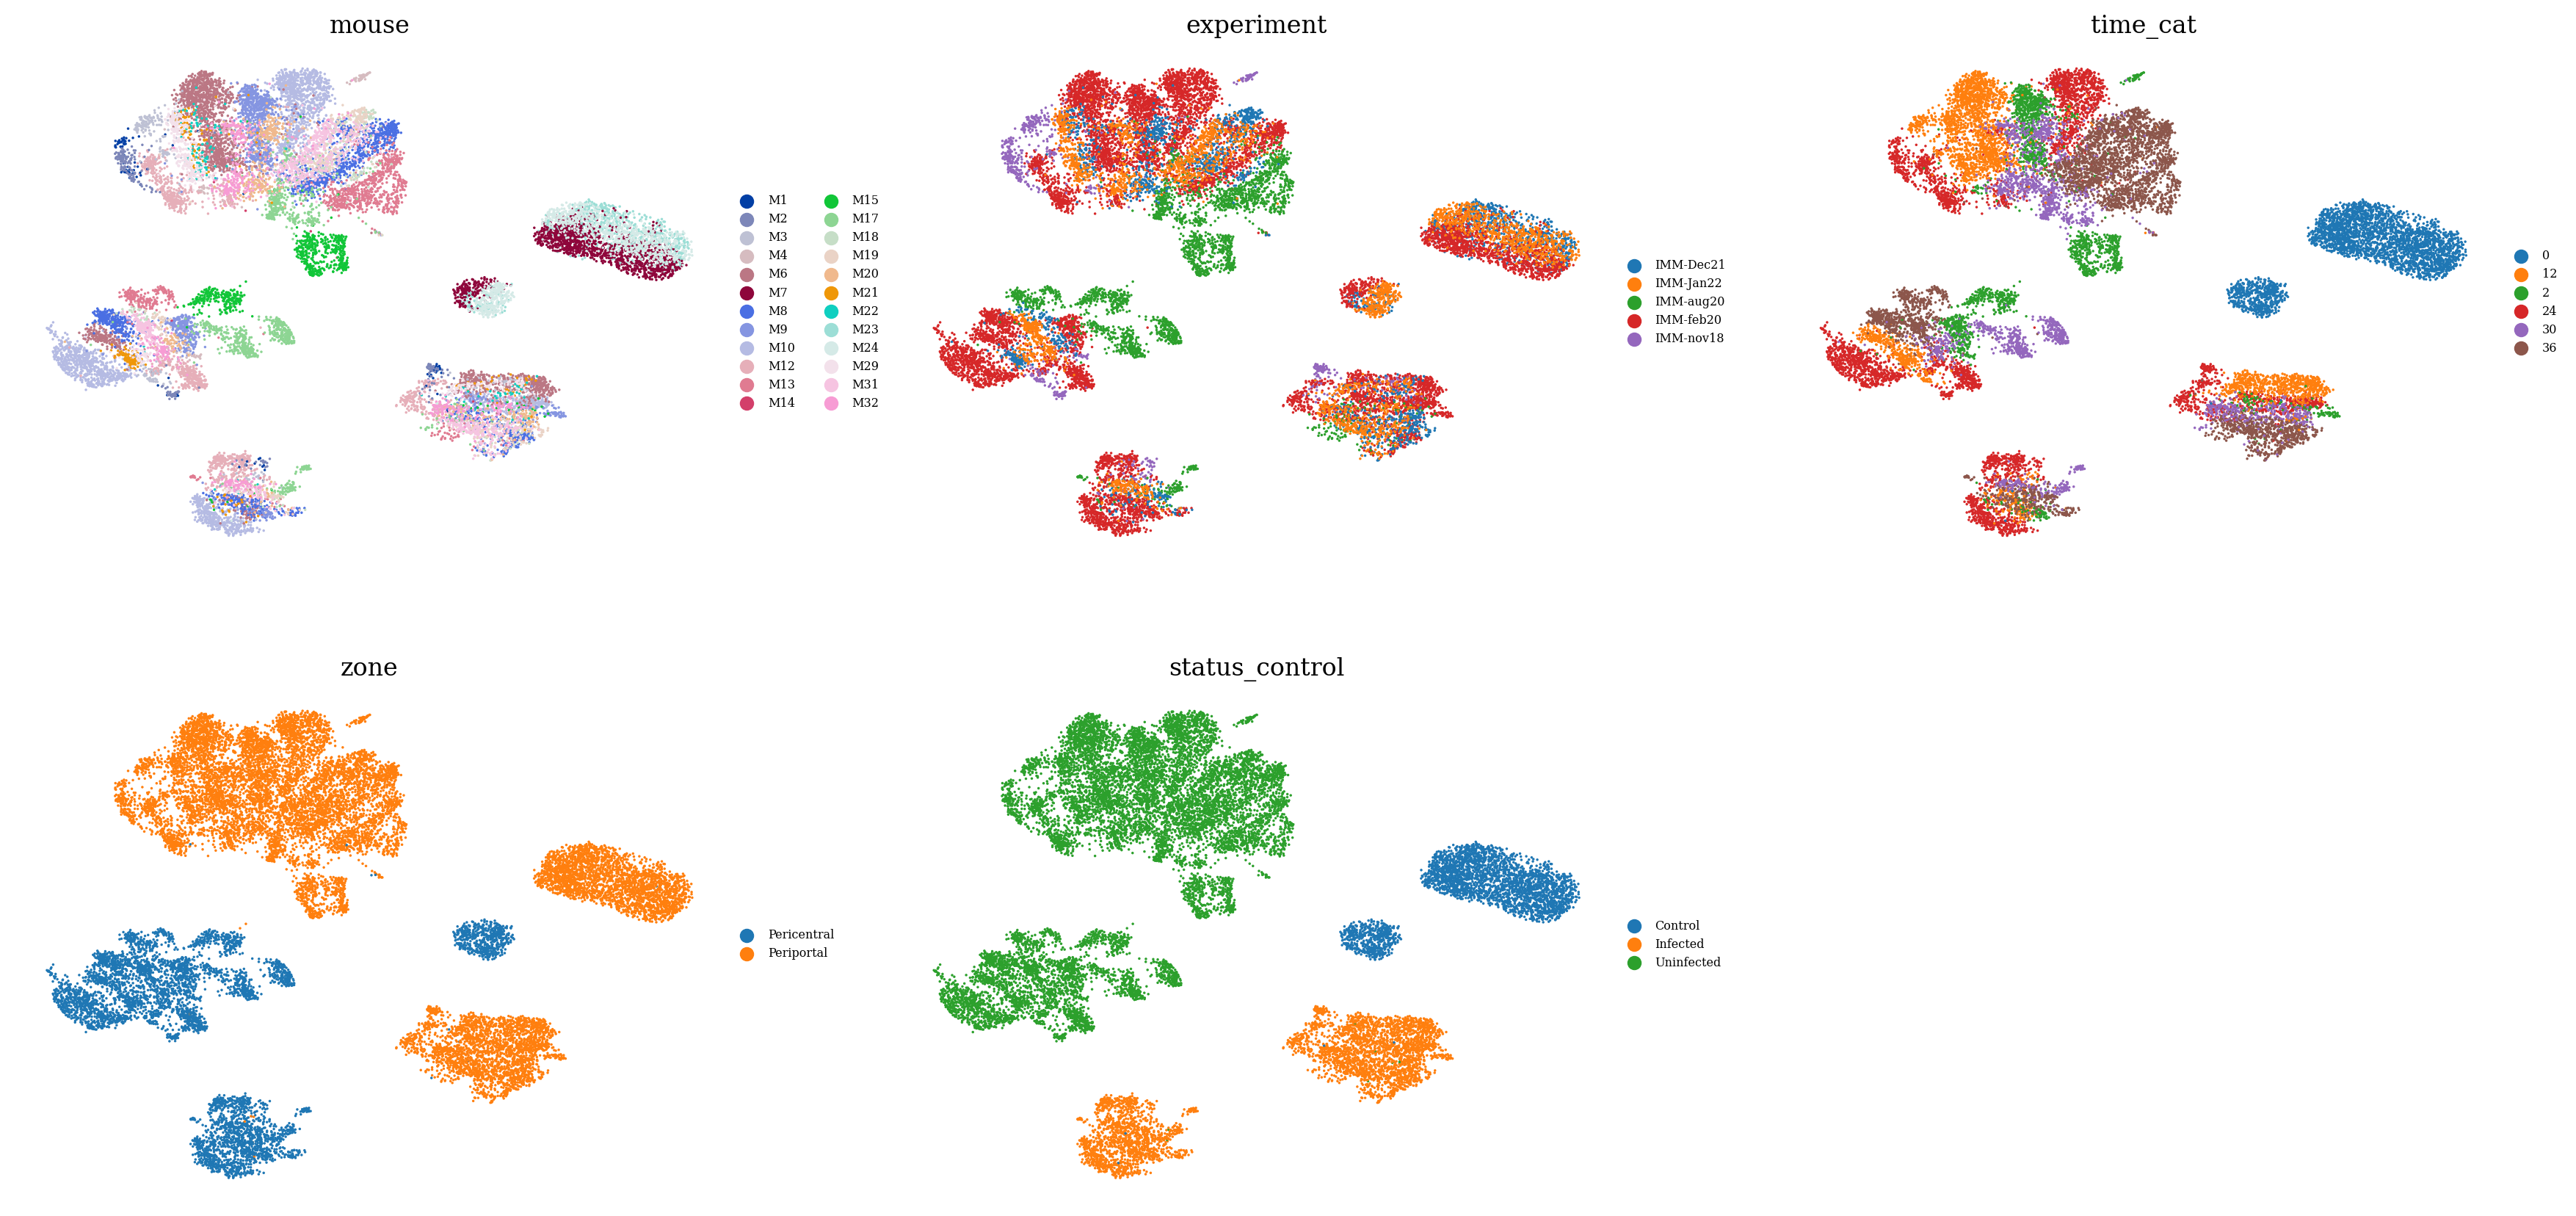

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

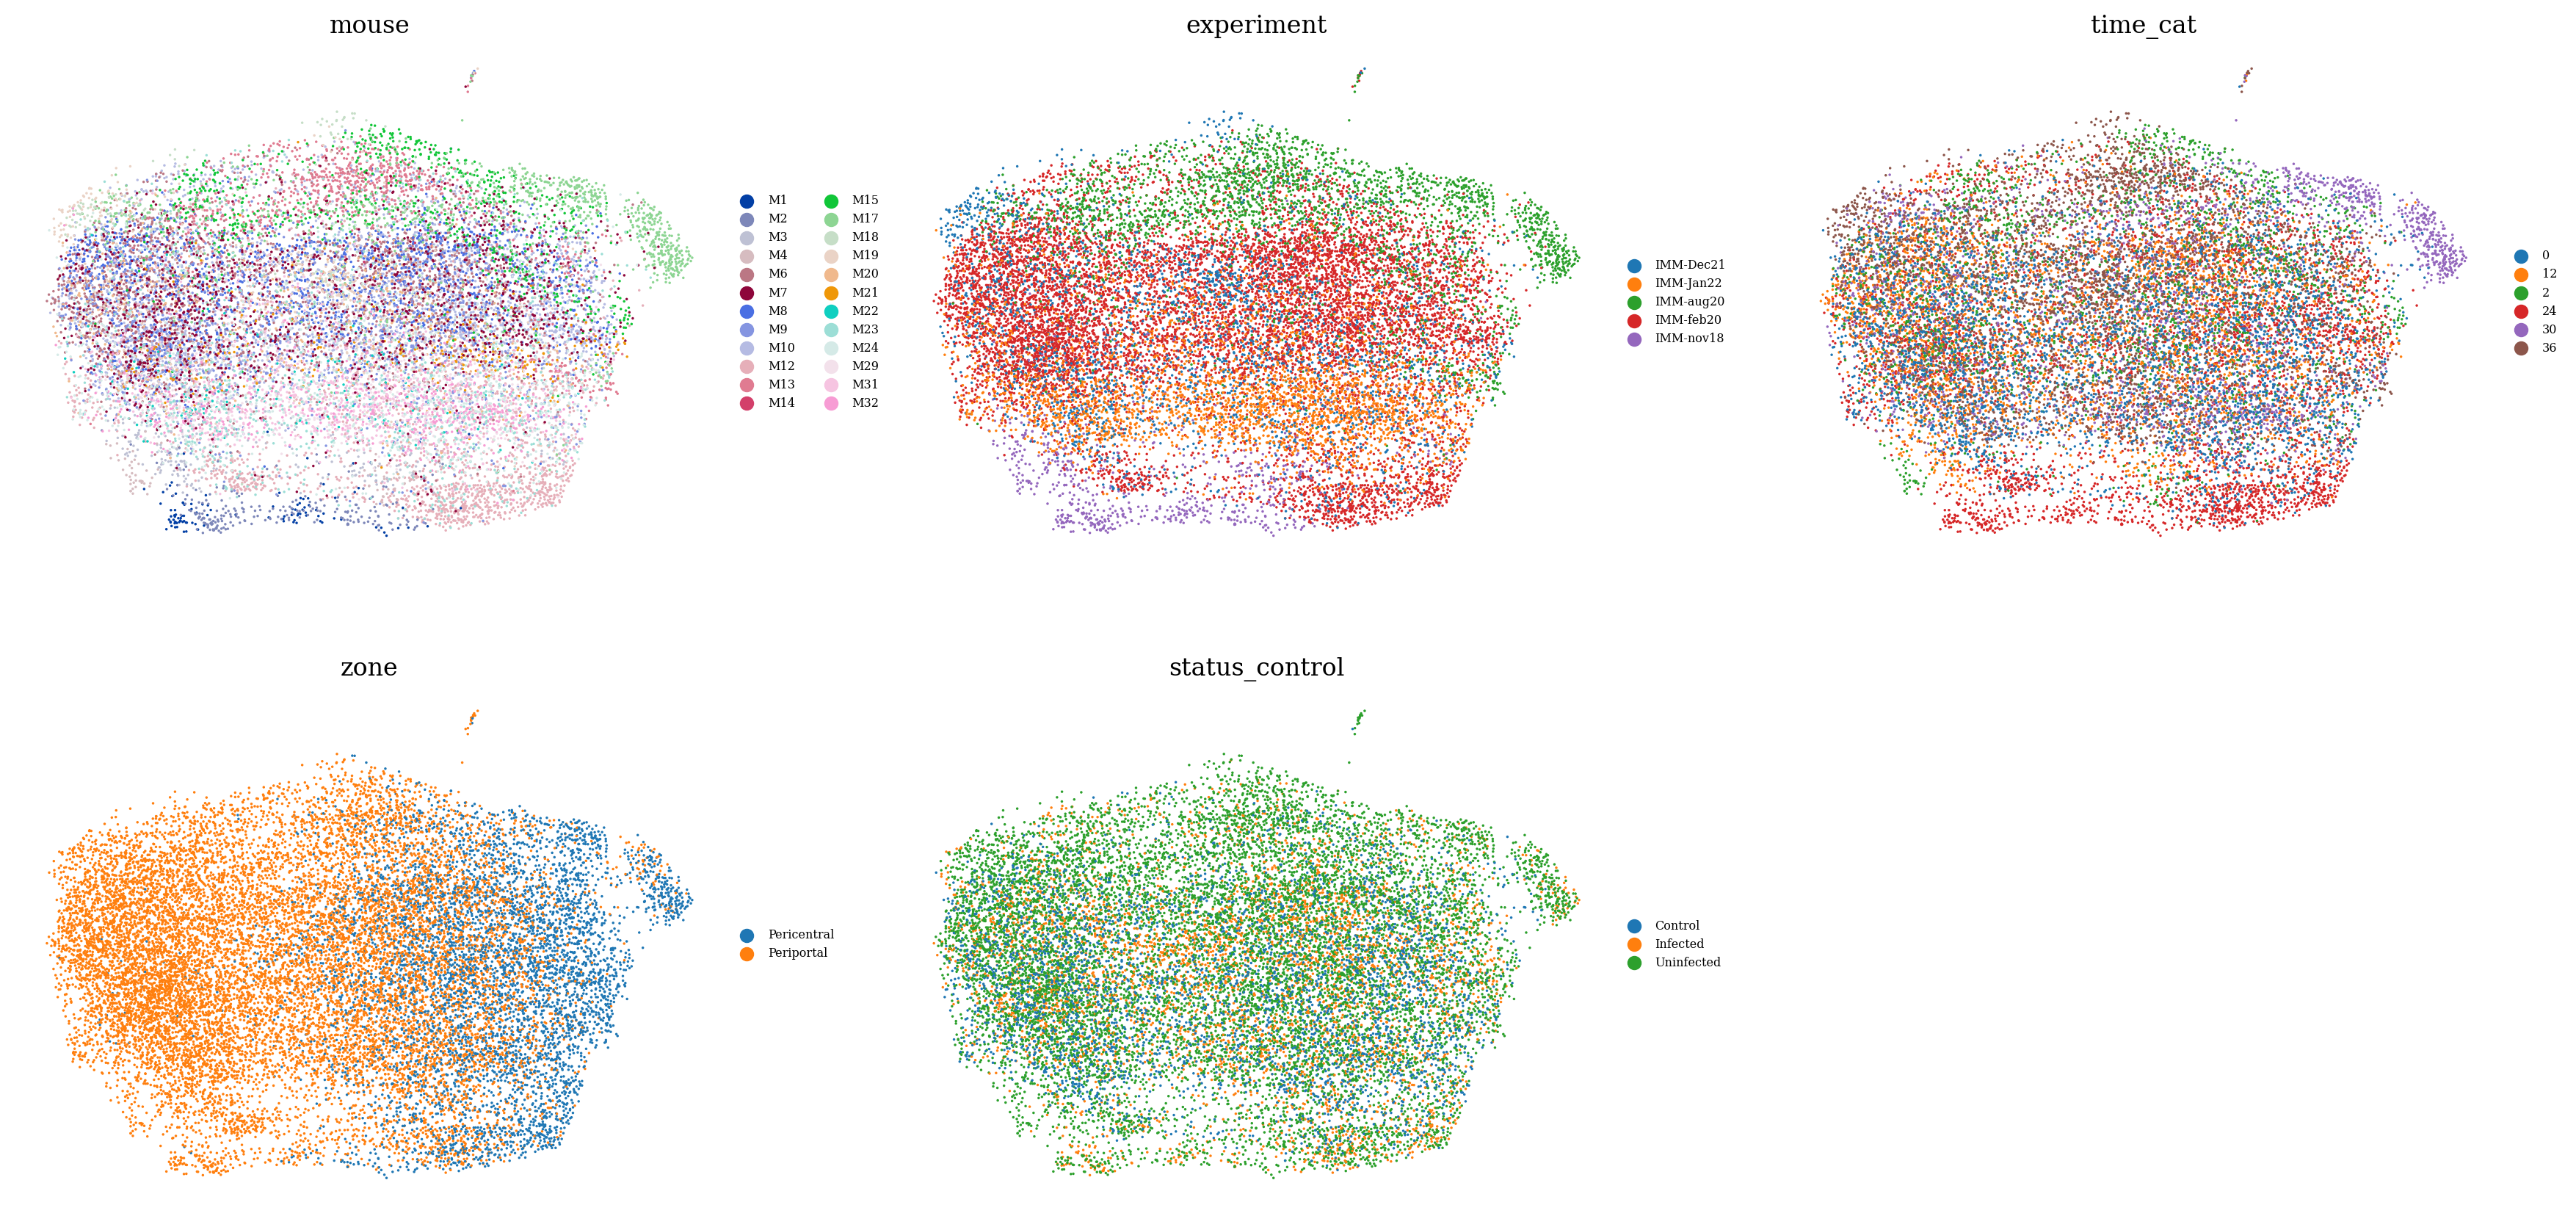

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  4%|▍         | 25/596 [00:00<00:02, 245.66it/s]

 10%|▉         | 57/596 [00:00<00:01, 285.15it/s]

 15%|█▍        | 89/596 [00:00<00:01, 298.61it/s]

 20%|██        | 120/596 [00:00<00:01, 302.79it/s]

 25%|██▌       | 151/596 [00:00<00:01, 304.63it/s]

 31%|███       | 182/596 [00:00<00:01, 305.58it/s]

 36%|███▌      | 213/596 [00:00<00:01, 306.50it/s]

 41%|████      | 244/596 [00:00<00:01, 305.59it/s]

 46%|████▌     | 275/596 [00:00<00:01, 306.10it/s]

 51%|█████▏    | 306/596 [00:01<00:00, 306.13it/s]

 57%|█████▋    | 337/596 [00:01<00:00, 305.62it/s]

 62%|██████▏   | 368/596 [00:01<00:00, 305.49it/s]

 67%|██████▋   | 399/596 [00:01<00:00, 306.45it/s]

 72%|███████▏  | 430/596 [00:01<00:00, 305.90it/s]

 77%|███████▋  | 461/596 [00:01<00:00, 306.50it/s]

 83%|████████▎ | 492/596 [00:01<00:00, 306.60it/s]

 88%|████████▊ | 523/596 [00:01<00:00, 306.86it/s]

 93%|█████████▎| 554/596 [00:01<00:00, 306.69it/s]

 98%|█████████▊| 585/596 [00:01<00:00, 306.75it/s]

100%|██████████| 596/596 [00:01<00:00, 303.99it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

1088

1120

1120

1152

1152

1184

1184

1216

1216

1248

1248

1280

1280

1312

1312

1344

1344

1376

1376

1408

1408

1440

1440

1472

1472

1504

1504

1536

1536

1568

1568

1600

1600

1632

1632

1664

1664

1696

1696

1728

1728

1760

1760

1792

1792

1824

1824

1856

1856

1888

1888

1920

1920

1952

1952

1984

1984

2016

2016

2048

2048

2080

2080

2112

2112

2144

2144

2176

2176

2208

2208

2240

2240

2272

2272

2304

2304

2336

In [23]:
np.mean(r2s)

0.9688383574082587

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)